In [ ]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm
from matplotlib import pyplot as plt
from NBinomRandomDataGenerator import NBinomRandomDataGenerator
import warnings
from scipy.stats import chi2
from autograd import hessian
import autograd.numpy as anp
import scipy.linalg as la

# Random Data Generation

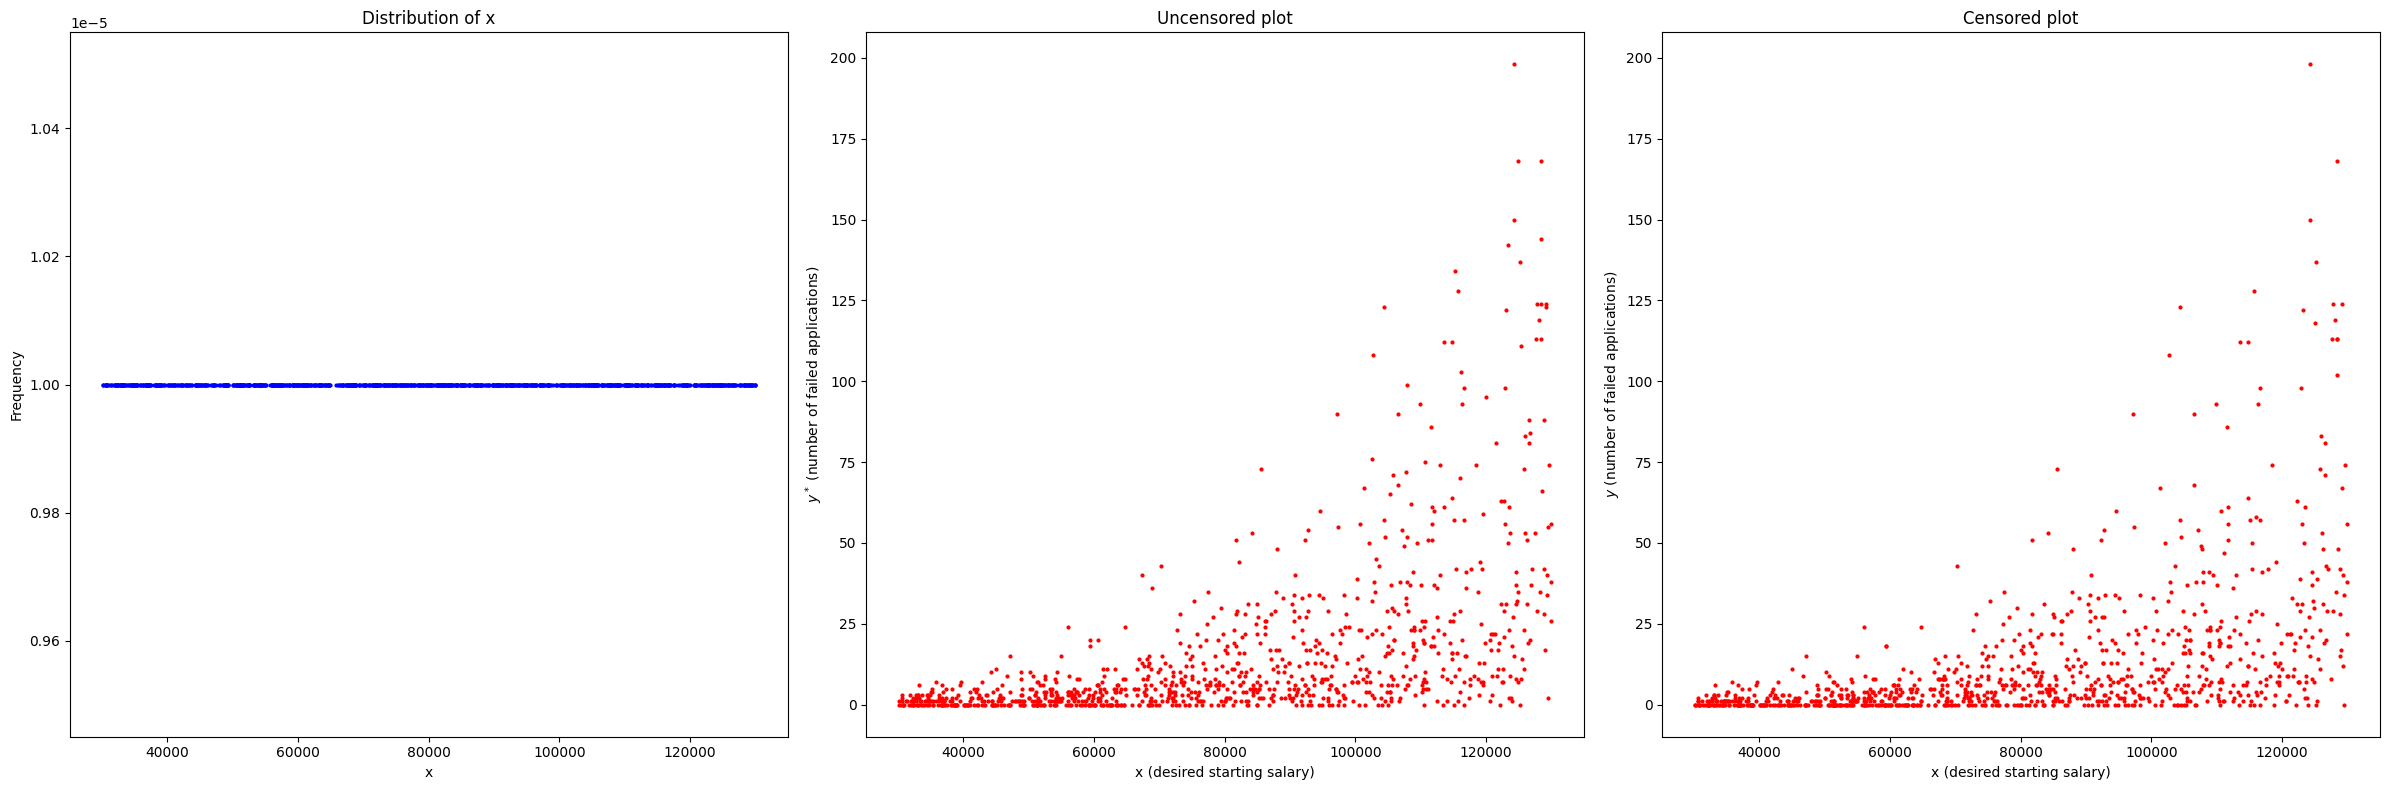

,Desired Starting Salary ($),Rejected Job Applications,Censored
0,56076,4,0
1,107812,31,1
2,80373,2,0
3,36261,3,0
4,98439,13,1
...,...,...,...
995,94831,7,0
996,68058,8,0
997,87386,11,0
998,96020,0,0


In [94]:
n = 1000
true_beta = np.array([1, -4e-5])

randomData = NBinomRandomDataGenerator(size=n, x_distribution='uniform', beta=true_beta)
data = randomData.createVaryingCensoredData(generate_plots=True)
data

In [95]:
# Organize data
x = data["Desired Starting Salary ($)"]
y = data["Rejected Job Applications"]
T = y.copy()
T[data['Censored'] == 0] = y + 1 #  If there is no censoring, all that matters is T > y
x = x.to_numpy()
y = y.to_numpy()
T = T.to_numpy()

# Maximum Likelihood Estimation

In [96]:
def nbinom_likelihood(b):
    """x, y, T are numpy arrays of length n"""

    def summation(p, T):
        return anp.sum([((1-p)**a) * (p) for a in range(T)])

    xb = b[0] + b[1]*x
    p = (anp.exp(xb) / (anp.exp(xb) + 1)) 
    p = anp.where(anp.isnan(p), 1, p) # Truncates overflow errors when xb is large
    
    sum = anp.array([summation(pi, Ti) for pi, Ti in zip(p, T)])
    censored_point = (y == T).astype(int)
    
    first_part = ((1-censored_point) * (anp.log(p) + y * anp.log(1-p)))
    second_part = censored_point * anp.log(1 - sum)
    Q = anp.where(anp.isnan(first_part), 0, first_part) +  anp.where(anp.isnan(second_part), 0, second_part) 
    # nan's are filled with zeros, because it likely means that point isn't censored.

    out = -1*anp.mean(Q)
    if anp.isinf(out):
        out = 1e10
    return out

In [97]:
warnings.simplefilter('ignore')
bounds = ((-1, 1),(-1, 1))
# This minimizer works a lot better, but it's really sensitive to initial conditions.

sol = opt.differential_evolution(nbinom_likelihood, x0=np.array([0, -0.005]), bounds=bounds) # maxiter=int(1e12)
print(sol)
beta_negbin = sol.x
beta_negbin

             message: Optimization terminated successfully.
             success: True
                 fun: 2.47638151382185
                   x: [ 9.976e-01 -4.124e-05]
                 nit: 36
                nfev: 1170
          population: [[ 9.976e-01 -4.129e-05]
                       [ 8.091e-01 -3.843e-05]
                       ...
                       [ 9.228e-01 -3.990e-05]
                       [ 9.555e-01 -3.781e-05]]
 population_energies: [ 2.476e+00  2.480e+00 ...  2.478e+00  2.500e+00]
                 jac: [-5.174e-03  5.880e-01]


array([ 9.97646941e-01, -4.12363725e-05])

## Marginal Effects: True Distribution

In [107]:
def E_Y(b, x): # The expected value of Y, given beta and x
    return np.exp(-1*(b[0] + b[1]*x))

def d_E_Y(b,x): # The derivative of E_Y wrt x
    return -1*b[1] * np.exp(-1*(b[0] + b[1]*x))

# Calculate the marginal effect for each xi
me_negbin = d_E_Y(beta_negbin, x)

## Marginal Effects: Tobit Model

In [108]:
def tobit_likelihood(b):
    """x, y, T are numpy arrays or pandas series of length n"""

    xb = b[1] + b[2]*x

    censored_point = (y == T).astype(int)
    first_part = (1-censored_point) * (np.log((1/b[0]) * norm.pdf((y - xb) / b[0])))
    second_part = censored_point * np.log(1 - norm.cdf((y - xb) / b[0]))
    
    Q = anp.where(anp.isnan(first_part), 0, first_part) +  anp.where(anp.isnan(second_part), 0, second_part) 
    # nan's are filled with zeros, because it likely means that point isn't censored.

    out = -1*np.mean(Q)
    if np.isinf(out):
        out = 1e10
    return out


In [109]:
warnings.simplefilter('ignore')
bounds = ((0, 500),(-1, 1), (-1,1))

# b0 is std_dev, b1 is beta0, b2 is beta1

sol = opt.differential_evolution(tobit_likelihood, x0=np.array([100, 0.5, 0.5]), bounds=bounds)
print(sol)
beta_tobit = sol.x
# In this case the marginal effect is just b[2]

me_tobit = np.ones_like(x) * beta_tobit[2]

             message: Optimization terminated successfully.
             success: True
                 fun: 3.4814425535280096
                   x: [ 2.233e+01 -8.626e-01  2.815e-04]
                 nit: 30
                nfev: 1535
          population: [[ 2.233e+01 -8.626e-01  2.815e-04]
                       [ 2.442e+01 -3.241e-02  1.993e-04]
                       ...
                       [ 2.486e+01 -8.287e-01  2.940e-04]
                       [ 1.899e+01 -2.104e-01  2.392e-04]]
 population_energies: [ 3.481e+00  3.513e+00 ...  3.495e+00  3.500e+00]


# Comparing Marginal Effects

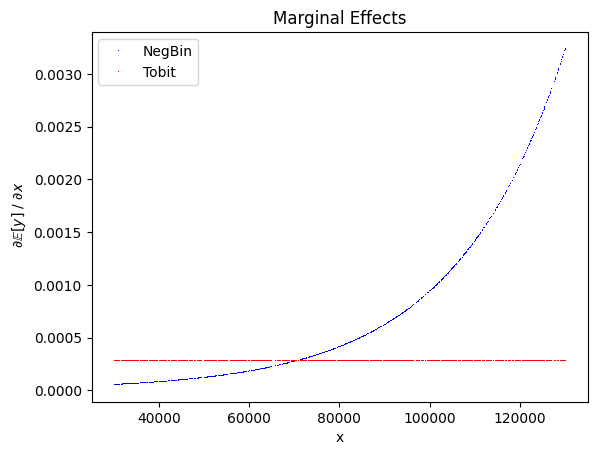

In [124]:
plt.title("Marginal Effects")
plt.plot(x, me_negbin, 'b,', label="NegBin")
plt.plot(x, me_tobit, 'r,', label="Tobit")
plt.xlabel("x")
plt.ylabel(" $\partial \mathbb{E}[y]$ / $\partial x$")
plt.legend()
plt.show()

# Inference

In [125]:
def positive_nbinom_likeli(b):
    return -1*nbinom_likelihood(b)

hess = hessian(positive_nbinom_likeli)
H = hess(beta_negbin)

# Calculate V
V = -1*la.inv(H)
V

array([[ 1.68900608e+01, -1.85827291e-04],
       [-1.85827291e-04,  2.25266727e-09]])

In [ ]:
# Wald test. Let's test that \beta_1 is not zero
# TODO: I could probably put this Wald test into a function and make it more general w/ R, r, etc.

v1 = V[1,1]
b1 = beta_negbin[1]
n = 100
alpha = 0.05

W = (b1 / (np.sqrt(v1 * (1/n))))**2
p = 1 - chi2.cdf(x=W, df=1)

print(f"Wald Statistic: {W}")
print(f"p value: {p}")

if p < alpha:
    print("Significance found: H_0 rejected")
else:
    print("Failed to reject")

Wald Statistic: 75.48555627653782
p value: 0.0
Significance found: H_0 rejected
